# Классификация заемщиков линейными моделями

## курс "Машинное обучение 1", программа AIMasters, 2024

## Студент: Вологдин Марк Данилович

## Реализация алгоритмов (5 баллов)

Ниже нужно написать собственную реализацию линейного классификатора с произвольной функцией потерь и реализацию функции и градиента функции потерь для логистической регрессии. Реализации можно частично проверить через юнит тесты. В этом блоке можно использовать только `numpy, scipy`.


В `BinaryLogisticLoss` вам нужно реализовать расчет лосса и его градиента для функции
$$L(w) = \frac{1}{N} \sum_{N} [\log(1 + \exp(-y_i\langle w, x_i\rangle))] + \lambda \lVert w \rVert^2_2, \quad y \in \{-1, 1\}$$

- `func(self, X, y, w)` — вычисление значения функции потерь на матрице признаков X, векторе ответов y с вектором весов w.
- `grad(self, X, y, w)` — вычисление значения градиента функции потерь на матрице признаков X, векторе ответов y с вектором весов w.

У обоих методов одинаковые аргументы:
- X - выборка объектов
- y - вектор ответов
- w - вектор коэффициентов модели

Вектор коэффициентов имеет вид: w = `[bias, weights]`, то есть нулевой элемент w - `bias`, остальное - веса, участвующие в скалярном произведении. **Важно:** `bias` не участвует в расчете слагаемого с $\lambda$.

Обратите внимание, что на матрица X на входе без столбца с 1 в начале. Пример изменения Х внутри кода функций:
```python
X_new = np.c_[np.ones(X.shape[0]), X]
```

In [ ]:
import numpy as np
import scipy
from scipy.special import expit
from scipy.special import logsumexp

class BinaryLogisticLoss():
    """
    Loss function for binary logistic regression.
    It should support l2 regularization.
    """

    def __init__(self, l2_coef):
        """
        Parameters
        ----------
        l2_coef - l2 regularization coefficient
        """
        self.l2_coef = l2_coef

    def func(self, X, y, w):
        """
        Get loss function value for data X, target y and coefficient w; w = [bias, weights].

        Parameters
        ----------
        X : numpy.ndarray
        y : 1d numpy.ndarray
        w : 1d numpy.ndarray

        Returns
        -------
        : float
        """
        X_new = np.c_[np.ones(X.shape[0]), X]
        loss = 0
        for i in range(X_new.shape[0]):
            z = -y[i] * X_new[i] @ w
            loss += logsumexp([0, z])
        loss = loss/X_new.shape[0] + self.l2_coef*w[1:]@w[1:]
        return loss
        pass

    def grad(self, X, y, w):
        """
        Get loss function gradient for data X, target y and coefficient w; w = [bias, weights].

        Parameters
        ----------
        X : numpy.ndarray
        y : 1d numpy.ndarray
        w : 1d numpy.ndarray

        Returns
        -------
        : 1d numpy.ndarray
        """

        X_new = np.c_[np.ones(X.shape[0]), X]
        grad = np.ndarray(w.shape[0])
        z = X_new @ w
        expit1 = expit(y * z)
        expit_invers = 1 - expit1
        grad = -np.dot( X_new.T, y*expit_invers)/X_new.shape[0]
        grad += 2*self.l2_coef*np.concatenate(([0],w[1:]))
        return grad
        pass

In [ ]:
loss_function = BinaryLogisticLoss(l2_coef=1.0)
X = np.array([
    [1, 2],
    [3, 4],
    [-5, 6]
])
y = np.array([-1, 1, 1])
w = np.array([1, 2, 3])
assert np.isclose(loss_function.func(X, y, w), 16.00008, atol=1e-5)

loss_function = BinaryLogisticLoss(l2_coef=0.0)
X = np.array([
    [10 ** 5],
    [-10 ** 5],
    [10 ** 5]
])
y = np.array([1, -1, 1])
w = np.array([1, 100])
assert np.isclose(loss_function.func(X, y, w), 0, atol=1e-5)

loss_function = BinaryLogisticLoss(l2_coef=0.0)
X = np.array([
    [10 ** 2],
    [-10 ** 2],
    [10 ** 2]
])
y = np.array([-1, 1, -1])
w = np.array([1, 100])
assert np.isclose(loss_function.func(X, y, w), 10000.333334, atol=1e-5)

loss_function = BinaryLogisticLoss(l2_coef=1.0)
X = np.array([
    [1, 2],
    [3, 4],
    [-5, 6]
])
y = np.array([-1, 1, 1])
w = np.array([1, 2, 3])
right_gradient = np.array([0.33325, 4.3335 , 6.66634])
assert np.isclose(loss_function.grad(X, y, w), right_gradient, atol=1e-5).all()

В `LinearModel` нужно реализовать линейную модель, поддерживающей обучение через стохастический градиентные спуск.

`__init__` — инициализатор класса с параметрами:
- loss_function — функция потерь, заданная классом
- batch_size — размер подвыборки, по которой считается градиент
- step_alpha — параметр шага градиентного спуска
- tolerance — критерий останова метода — модуль разности значений функции потерь на соседних итерациях метода меньше tolerance, не весов.
- max_iter — максимальное число итераций (эпох)

`fit(self, X, y, w_0=None)` — обучение линейной модели

- X — выборка объектов
- y — вектор ответов
- w_0 — начальное приближение вектора коэффициентов, если None, то необходимо инициализировать внутри метода. w_0 имеет вид `[bias_0, weights_0]`.

`predict_proba(self, X)` — получение вероятностей для 2х классов
- X — выборка объектов

Вы можете поменять формат изменения шага градиентного спуска, по дефолту предполагается, что можно использовать просто `step_alpha`.

Про sgd: нет необходимости проводить честное семплирование для каждого батча в методе стохасического градиентного спуска. Вместо этого предлагается в начале одной эпохи сгенерировать случайную перестановку индексов объектов, а затем последовательно выбирать объекты для нового батча из элементов этой перестановки. Псевдокод:
```python
epoch_rand_indexes = np.random.permutation(X.shape[0])
inner_cycle_length = int(np.ceil(X.shape[0] / self.batch_size))

for i in range(inner_cycle_length):
    start_index = self.batch_size * i
    finish_index = self.batch_size * (i + 1)
    batch_indexes = epoch_rand_indexes[start_index:finish_index]
    # тут считаем градиент только по batch_indexes
```

Еще несколько советов:

В промежуточных вычислениях стоит избегать вычисления $exp(−y_i⟨x_i,w⟩)$, иначе может произойти переполнение.
Вместо этого следует напрямую вычислять необходимые величины с помощью специализированных для этого функций: `np.logaddexp, scipy.special.logsumexp и scipy.special.expit`. В ситуации, когда вычисления экспоненты обойти не удаётся, можно воспользоваться процедурой «клипинга» (функция `numpy.clip`).


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
from scipy.special import expit

class LinearModel:
    def __init__(
        self,
        loss_function,
        batch_size=100,
        step_alpha=1,
        tolerance=1e-5,
        max_iter=1000,
        random_seed=0,
        **kwargs
    ):
        """
        Parameters
        ----------
        loss_function : BaseLoss inherited instance
            Loss function to use
        batch_size : int
        step_alpha : float
        tolerance : float
            Tolerace for stop criterio.
        max_iter : int
            Max amount of epoches in method.
        """
        self.loss_function = loss_function
        self.batch_size = batch_size
        self.step_alpha = step_alpha
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_seed = random_seed

        np.random.seed(random_seed)

    def fit(self, X, y, w_0=None):
        """
        Parameters
        ----------
        X : numpy.ndarray or scipy.sparse.csr_matrix
            2d matrix, training set.
        y : numpy.ndarray
            1d vector, target values.
        w_0 : numpy.ndarray
            1d vector in binary classification.
            Initial approximation for SGD method - [bias, weights]
        """

        if w_0 is None:
            w_k = np.zeros(X.shape[1] + 1)  # [bias, weights]
        else:
            w_k = w_0
        print()
        for epoch in range(self.max_iter):

            # Перемешиваем индексы данных в начале каждой эпохи
            epoch_rand_indexes = np.random.permutation(X.shape[0])
            inner_cycle_length = int(np.ceil(X.shape[0] / self.batch_size))

            loss_old = loss_function.func(X, y, w_k)

            for i in range(inner_cycle_length):
                start_index = self.batch_size * i
                finish_index = self.batch_size * (i + 1)
                batch_indexes = epoch_rand_indexes[start_index:finish_index]
                grad = loss_function.grad(X[batch_indexes], y[batch_indexes], w_k)
                w_k -= self.step_alpha * grad


            loss_new = loss_function.func(X, y, w_k)

            if np.isclose(loss_old, loss_new, atol=self.tolerance):
                #print(f"Остановлено на {epoch + 1}-й эпохе.")
                break

        # Финальные веса сохраняются в w_k
        self.weights_ = w_k

    def predict_proba(self, X):
        """
        Parameters
        ----------
        X : numpy.ndarray or scipy.sparse.csr_matrix
            2d matrix, test set.
        Returns
        -------
        : numpy.ndarray
            probs, shape=(X.shape[0], 2)
        """

        linear_combination = X.dot(self.weights_[1:]) + self.weights_[0]


        probs_1 = expit(linear_combination)
        probs_0 = 1 - probs_1


        probs = np.vstack([probs_0, probs_1]).T
        return probs

In [ ]:
# обратите внимание, что тут достаточно простой тест
# ниже еще есть проверка для данных из data
X1 = np.random.randint(1, 4, (1000, 10))
X2 = np.random.randint(-4, 0, (1000, 10))
X = np.vstack((X1, X2))
y = np.array([-1] * 1000 + [1] * 1000)
loss_function = BinaryLogisticLoss(l2_coef=0.1)
linear_model = LinearModel(
    loss_function=loss_function,
    batch_size=100,
    step_alpha=1,
    tolerance=1e-4,
    max_iter=1000,
)
linear_model.fit(X, y)
prediction_probs = linear_model.predict_proba(X)
predictions = (prediction_probs > 0.5).astype('int')[:, 1] * 2 - 1
assert np.isclose(predictions, y).all()

## Эксперименты (5 баллов)

Эксперименты будем проводить на [датасете](https://www.kaggle.com/competitions/home-credit-default-risk/overview) по классификации заемщиков на плохих (target = 1: клиент с "payment difficulties") и хороших (target = 0: все остальные). Для экспериментов будем использовать лишь основной файл `application_train.csv`, а также перекодируем таргет в метки -1, 1.

Описание колонок находится в файле `description.csv`.

Для начала мы за вас считаем данные и поделим на обучение и тест.

Код в чтение, разбиение и предобработке менять не нужно.

Выполняя задания, не забывайте про [устав](https://t.me/c/2206639786/270/271).

In [ ]:
!ls

application_train.csv  sample_data


In [ ]:
# не меняем код
import pandas as pd
pd.options.display.max_columns = 100
pd.options.display.max_rows = 150


data = pd.read_csv('application_train.csv')
data.columns = [
    '_'.join([word.lower() for word in col_name.split(' ') if word != '-']) for col_name in data.columns
]
data.target = data.target.map({0: -1, 1: 1})
data.head(3)

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,occupation_type,cnt_fam_members,region_rating_client,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,organization_type,ext_source_1,ext_source_2,ext_source_3,apartments_avg,basementarea_avg,years_beginexpluatation_avg,years_build_avg,commonarea_avg,elevators_avg,...,apartments_medi,basementarea_medi,years_beginexpluatation_medi,years_build_medi,commonarea_medi,elevators_medi,entrances_medi,floorsmax_medi,floorsmin_medi,landarea_medi,livingapartments_medi,livingarea_medi,nonlivingapartments_medi,nonlivingarea_medi,fondkapremont_mode,housetype_mode,totalarea_mode,wallsmaterial_mode,emergencystate_mode,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,...,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,-1,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,...,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,-1,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# не меняем код
test_idx = data.sk_id_curr % 10 >= 7
data_dict = dict()
data_dict['tst'] = data.loc[test_idx].reset_index(drop=True)
data_dict['tr'] = data.loc[~test_idx].reset_index(drop=True)

for key, df in data_dict.items():
    print(key, 'shape:', df.shape)

tst shape: (92221, 122)
tr shape: (215290, 122)


In [ ]:
# не меняем код
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

features = data.select_dtypes(np.number).drop(columns=['target', 'sk_id_curr']).columns

X_tr, X_tst = data_dict["tr"][features].to_numpy(), data_dict["tst"][features].to_numpy()
y_tr, y_tst = data_dict["tr"]["target"].to_numpy(), data_dict["tst"]["target"].to_numpy()


prep = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

prep.fit(X_tr)

X_tr = prep.transform(X_tr)
X_tst = prep.transform(X_tst)

Инициализируйте написанный выше лосс и классификатор, для `BinaryLogisticLoss` возьмите параметр `l2_coef=0.1`, параметры `LinearModel` нужно подобрать так, чтобы [roc_auc_score](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.roc_auc_score.html) был больше 0.72.

In [ ]:
loss_function = BinaryLogisticLoss(l2_coef=0.1)
clf = LinearModel(
    loss_function=loss_function,
    batch_size=1000,
    step_alpha=1/3,
    tolerance=1e-5,
    max_iter=50,
)

In [ ]:
clf.fit(X_tr, y_tr)

In [ ]:
from sklearn.metrics import roc_auc_score
assert roc_auc_score(y_tst, clf.predict_proba(X_tst)[:, 1]) > 0.72

Ура! Ваша модель что-то может :)

Теперь нужно поисследовать реализацию [LogisticRegression](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html) в sklearn.

Сравните различные `solver` по времени обучения/качеству на тесте. Напишите выводы.

Выбейте на тесте больше `0.737` roc_auc_score.
Для поиска лучшей модели можно использовать:
- optuna
- [GridSearchCV](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.GridSearchCV.html)
- свои наблюдения и интуицию


In [ ]:
import time
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


solvers = ['liblinear', 'lbfgs', 'newton-cg', 'saga', 'sag','newton-cholesky']


results = []


for solver in solvers:
    # Засекаем время
    start_time = time.time()


    model = LogisticRegression(solver=solver, max_iter=300)
    model.fit(X_tr, y_tr)


    end_time = time.time()
    training_time = end_time - start_time

    y_pred_proba = model.predict_proba(X_tst)[:, 1]
    roc_auc = roc_auc_score(y_tst, y_pred_proba)


    results.append({
        'solver': solver,
        'training_time': training_time,
        'roc_auc': roc_auc
    })

df_results = pd.DataFrame(results)

C:\Users\Markelo\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Markelo\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


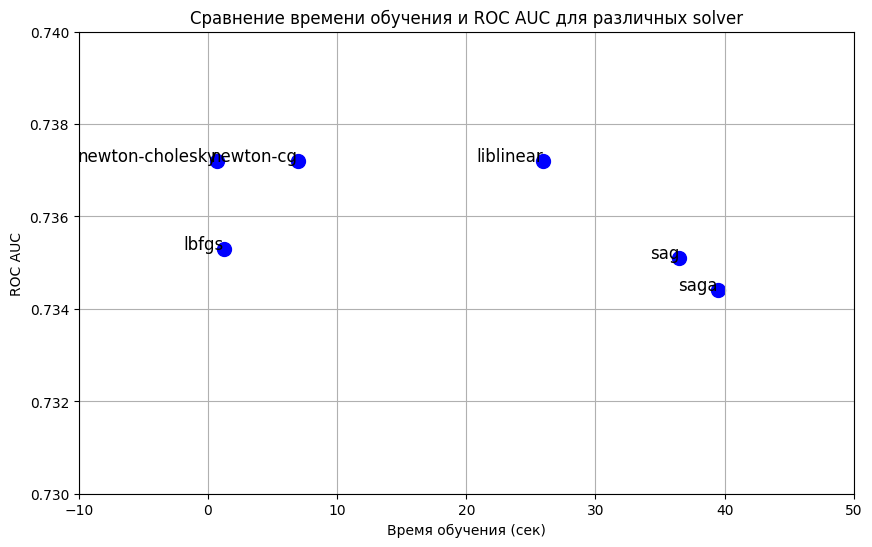

In [ ]:

x_min, x_max = -10, 50       # Задаем диапазон по времени (ось X) (-10 для наглядности)
y_min, y_max = 0.73, 0.74     # Задаем диапазон по ROC AUC (ось Y)

plt.figure(figsize=(10, 6))
plt.scatter(df_results['training_time'], df_results['roc_auc'], color='blue', s=100)

for i, row in df_results.iterrows():
    plt.text(row['training_time'], row['roc_auc'], row['solver'], fontsize=12, ha='right')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.title('Сравнение времени обучения и ROC AUC для различных solver')
plt.xlabel('Время обучения (сек)')
plt.ylabel('ROC AUC')
plt.grid(True)
plt.show()

In [ ]:
#Вывод пользуемся newton-cholesky если не говорить про остальные гиперпараметры

In [ ]:
from sklearn.metrics import roc_auc_score
import optuna
from tqdm.notebook import tqdm

def my_objective(
    trial: optuna.trial.Trial, # нечто оптюновское

    X_tr, X_tst, y_tr, y_tst # данные
):
    solver_penalty = trial.suggest_categorical(
        'solver_penalty',
        [
            'liblinear_l1',
            'liblinear_l2',
            'lbfgs_l2',
            'lbfgs_None',
            'newton-cg_l2',
            'newton-cg_None',
            'newton-cholesky_l2',
            'newton-cholesky_None',
            'saga_l1',
            'sag_l2',
            'sag_None',
            'saga_l2',
            'saga_elasticnet',
            'saga_None',
        ]
    )

    solver, penalty = solver_penalty.split('_')
    penalty = None if penalty == 'None' else penalty

    params = {
        'penalty': penalty,
        'solver': solver,
        'fit_intercept': True,
        'max_iter': trial.suggest_int('max_iter', 100, 300),  # Увеличен диапазон max_iter
    }

    if penalty is not None:
        params['C'] = trial.suggest_float('C', 1e-5, 100, log=True)

    if penalty == 'elasticnet':
        params['l1_ratio'] = trial.suggest_float('l1_ratio', 0, 1)


    model = LogisticRegression(**params)
    model.fit(X_tr, y_tr)

    y_pred = model.predict(X_tst)
    score = roc_auc_score(y_tst, model.predict_proba(X_tst)[:, 1])

    return score # возвращает одно значение - скор


In [ ]:
study = optuna.create_study(sampler=None, direction='maximize')

from functools import partial

# Нужно сделать так, чтобы наша функция-objective в итоге принимала только аргумент trial.
# Поэтому зафиксируем заранее все остальные
obj_func = partial(my_objective, X_tr=X_tr, X_tst=X_tst, y_tr=y_tr, y_tst=y_tst)

study.optimize(obj_func, n_trials=100, n_jobs=4, gc_after_trial=True) # есть еще аргумент timeout. optimize можно отсановить через Ctrl + C (кнопка стоп на панели ноутбука) с сохранением всей истории

[I 2024-11-11 06:36:31,205] A new study created in memory with name: no-name-d4ecdd0f-338d-4e3c-a636-31ea17f39e75
[I 2024-11-11 06:36:32,382] Trial 2 finished with value: 0.7380456176461836 and parameters: {'solver_penalty': 'newton-cholesky_None', 'max_iter': 103}. Best is trial 2 with value: 0.7380456176461836.
[I 2024-11-11 06:36:33,212] Trial 1 finished with value: 0.7352817323014506 and parameters: {'solver_penalty': 'lbfgs_None', 'max_iter': 104}. Best is trial 2 with value: 0.7380456176461836.
[I 2024-11-11 06:36:33,271] Trial 0 finished with value: 0.7352817323014506 and parameters: {'solver_penalty': 'lbfgs_None', 'max_iter': 256}. Best is trial 2 with value: 0.7380456176461836.
[I 2024-11-11 06:36:34,124] Trial 4 finished with value: 0.7352817323014506 and parameters: {'solver_penalty': 'lbfgs_None', 'max_iter': 177}. Best is trial 2 with value: 0.7380456176461836.
[I 2024-11-11 06:36:39,167] Trial 7 finished with value: 0.7295527907237579 and parameters: {'solver_penalty': '

In [ ]:
solver, penalty = study.best_params['solver_penalty'].split('_')
penalty = None if penalty == 'None' else penalty
clf = LogisticRegression(solver= solver, penalty = penalty, max_iter = study.best_params['max_iter'])
clf.fit(X_tr, y_tr)

LogisticRegression(max_iter=103, penalty=None, solver='newton-cholesky')

In [ ]:
assert roc_auc_score(y_tst, clf.predict_proba(X_tst)[:, 1]) > 0.737

Нарисуйте график `feature - weight`, показывающий `top_k` (на ваш выбор) признаков по модулю веса и их значения весов. <br>
Признаки должны идти по убыванию модуля веса. <br>
Лучше использовать [barplot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html) или аналоги из других библиотек. <br>
Опишите наблюдения, используя описания признаков в `description.csv`.

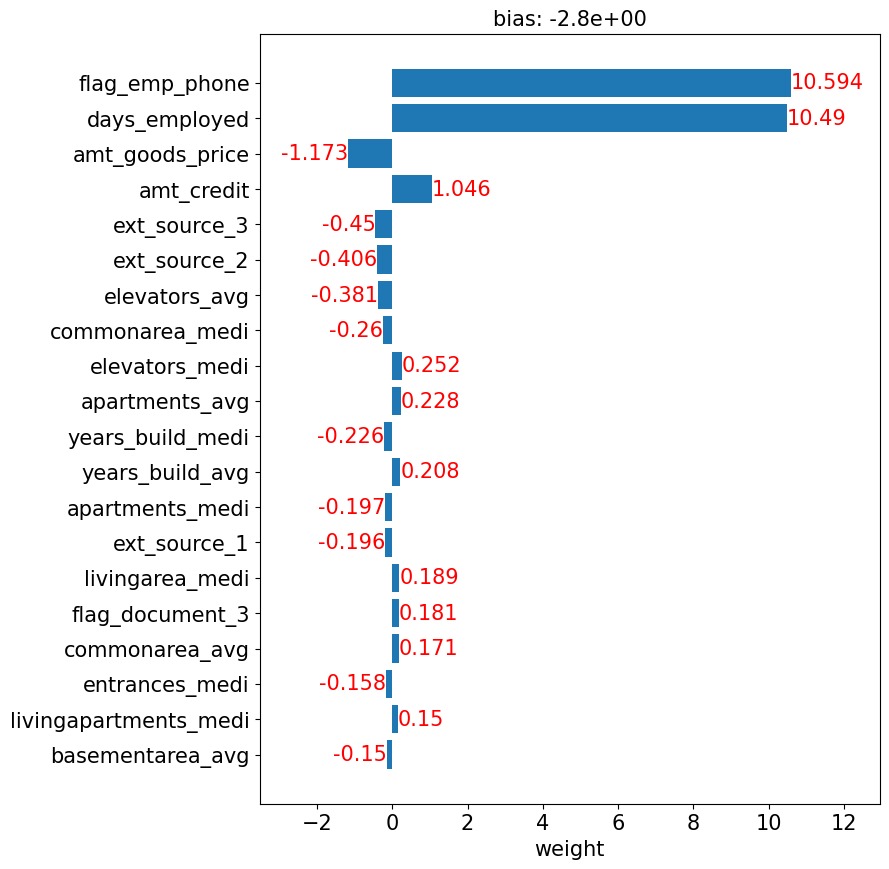

In [ ]:
def plot_weights(model, features, top_k=20):
    '''
    рисует значения весов линейной модели при признаках

    top_k: рисовать первые top_k весов по модулю
    '''
    # подготовка необходимого
    num_features_to_plot = min(top_k, len(features))
    weights = model.coef_[0] if len(model.coef_.shape) > 1 else model.coef_ # классификация vs регрессия
    sorted_idx = np.argsort(-np.abs(weights))
    bias = model.intercept_[0] if not isinstance(model.intercept_, float) else model.intercept_ # классификация vs регрессия

    fig, ax = plt.subplots(figsize=(8, num_features_to_plot / 2))

    # сами бары
    container = ax.barh(y=features[sorted_idx][:top_k][::-1], width=weights[sorted_idx][:top_k][::-1])

    # приписать к ним значения весов
    ax.bar_label(container, weights[sorted_idx][:top_k][::-1].round(3), color='red', fontsize=15)

    # настройка ах'a
    ax.margins(0.2, 0.05)
    ax.set_title(f'bias: {bias:.1e}', fontsize=15)
    ax.tick_params(axis='both', labelsize=15)
    ax.set_xlabel('weight', fontsize=15)

    plt.show()

plot_weights(clf, features, top_k=20)

In [ ]:
#кажется логичным что наличие рабочего телефона и большой стаж на текущем месте дают основания полагать что клиент платежеспособен, а большая сумма потребительского кредита наоборот

Выведите топ признаков с наибольшим/наименьшим абсолютным весом.<br>
Опишите наблюдения (ответьте на вопрос: правда ли, что если признак `X` больше/меньше, то вероятность дефолта клиента выше/ниже?).

In [ ]:
weights = clf.coef_[0] if len(model.coef_.shape) > 1 else clf.coef_ # классификация vs регрессия
sorted_idx = np.argsort(-np.abs(weights))
bias = clf.intercept_[0] if not isinstance(clf.intercept_, float) else clf.intercept_ # классификация vs регрессия

# Список топ-10 признаков по абсолютному значению веса
top_features = [(features[i], weights[i]) for i in sorted_idx[:10]]
print("Топ-10 признаков по абсолютному значению веса:")
for feature, weight in top_features:
    print(f"{feature}: {weight:.3f}")

Топ-10 признаков по абсолютному значению веса:
flag_emp_phone: 10.594
days_employed: 10.490
amt_goods_price: -1.173
amt_credit: 1.046
ext_source_3: -0.450
ext_source_2: -0.406
elevators_avg: -0.381
commonarea_medi: -0.260
elevators_medi: 0.252
apartments_avg: 0.228


In [ ]:
#про первые четыре признака да , 4 можно описать так: сумма не потреб кредита =>
# чем больше тем более глобальная цель(недвижимость, образование ) как правило такие кредиты чаще выплачивают
#следующие два: оценка надежности ресурса данных как я понял по идее должны быть с +
# elevators_avg and elevators_medi средняя оценка здания площади для полноценной оценки я бы покопался что именно входит в оценку тк
# возраст здания - скорее минус, а средняя площадь скорее плюс и тд